In [1]:
!pip install fastai --upgrade
!pip install timm wwf

Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (2.2.5)


In [2]:
!wget https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1 -O erm.zip

--2021-02-08 16:54:56--  https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/cb3g53z4pbtaqvl/erm.zip [following]
--2021-02-08 16:54:57--  https://www.dropbox.com/s/dl/cb3g53z4pbtaqvl/erm.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc611465e8c5dbe3b69d8f863df7.dl.dropboxusercontent.com/cd/0/get/BIgAxPRBhS9pA-GxCDmtwOKQVfTr5BeWnHNPwvIKgMpyVKBmeQIXnO2RwxDqDZMCkEbmazEvsVqbjrNXU9kCk1KnesGrloAvgxsqnfxt-a1JP5py8x2X7pbBy8kOBtbcuu8/file?dl=1# [following]
--2021-02-08 16:54:57--  https://uc611465e8c5dbe3b69d8f863df7.dl.dropboxusercontent.com/cd/0/get/BIgAxPRBhS9pA-GxCDmtwOKQVfTr5BeWnHNPwvIKgMpyVKBmeQIXnO2RwxDqDZMCkEbmazEvsVqbjrNXU9kCk1KnesGrloAvgxsqnfxt-a1JP5py8x2X7pbBy8kO

In [3]:
!unzip erm.zip

Archive:  erm.zip
replace dataset/test/no/anonymized_1421704.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: dataset/test/no/anonymized_1421704.jpg  
replace dataset/test/no/anonymized_336537.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset/test/no/anonymized_336537.jpg  
  inflating: dataset/test/no/anonymized_569526.jpg  
  inflating: dataset/test/no/anonymized_196860.jpg  
  inflating: dataset/test/no/anonymized_920184.jpg  
  inflating: dataset/test/no/anonymized_1348815.jpg  
  inflating: dataset/test/no/anonymized_225304.jpg  
  inflating: dataset/test/no/anonymized_816099.jpg  
  inflating: dataset/test/no/anonymized_260226.jpg  
  inflating: dataset/test/no/anonymized_1619231.jpg  
  inflating: dataset/test/no/anonymized_1314755.jpg  
  inflating: dataset/test/no/anonymized_1182585.jpg  
  inflating: dataset/test/no/anonymized_656024.jpg  
  inflating: dataset/test/no/anonymized_198917.jpg  
  inflating: dataset/test/no/anonymized_246204.jpg  
  infla

In [4]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [5]:
path = Path('dataset/')
trainPath = path/'train'
testPath = path/'test'

In [6]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

In [7]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=64)

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='efficientnet_b1')
]

In [9]:
import timm
timm.list_models('*efficientnet_b1*')

['efficientnet_b1',
 'efficientnet_b1_pruned',
 'tf_efficientnet_b1',
 'tf_efficientnet_b1_ap',
 'tf_efficientnet_b1_ns']

In [10]:
learn = timm_learner(dls512, 'efficientnet_b1',cbs = callbacks,metrics=[accuracy,Precision(),Recall()]).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b1-533bc792.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-533bc792.pth


SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=1.737800812406931e-05)

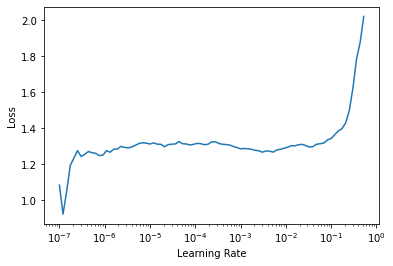

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.262161,0.942247,0.519878,0.559671,0.396501,00:26


Better model found at epoch 0 with valid_loss value: 0.9422470927238464.


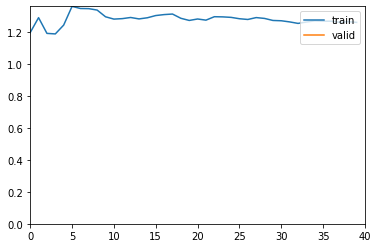

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.312705,0.965271,0.530581,0.578947,0.384840,00:30
1,1.287941,0.945416,0.522936,0.561753,0.411079,00:29
2,1.269543,0.937908,0.522936,0.562753,0.405248,00:29
3,1.259805,0.938210,0.518349,0.557851,0.393586,00:29
4,1.259851,0.910908,0.519878,0.557312,0.411079,00:30
5,1.243729,0.904444,0.524465,0.561069,0.428571,00:29
6,1.246358,0.893187,0.530581,0.569231,0.431487,00:30
7,1.229398,0.896317,0.532110,0.571429,0.431487,00:29
8,1.232916,0.900818,0.529052,0.570850,0.411079,00:30
9,1.220125,0.892706,0.535168,0.573034,0.446064,00:30


Better model found at epoch 0 with valid_loss value: 0.9652711153030396.


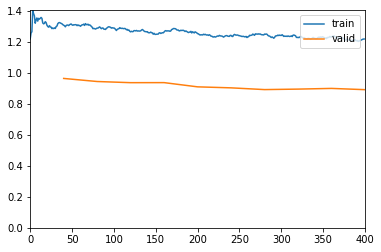

Better model found at epoch 1 with valid_loss value: 0.945416271686554.
Better model found at epoch 2 with valid_loss value: 0.9379079341888428.
Better model found at epoch 4 with valid_loss value: 0.9109076857566833.
Better model found at epoch 5 with valid_loss value: 0.9044435024261475.
Better model found at epoch 6 with valid_loss value: 0.8931869864463806.
Better model found at epoch 9 with valid_loss value: 0.8927057981491089.


In [12]:
learn.fine_tune(10,base_lr=1e-5)

In [13]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

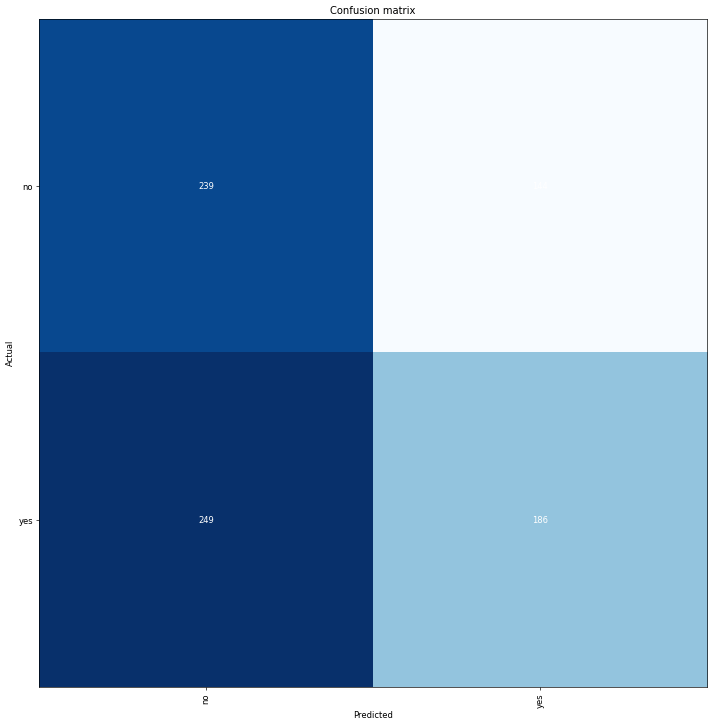

In [14]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [15]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.519559919834137.


(#4) [0.8841888308525085,0.519559919834137,0.5636363636363636,0.42758620689655175]

In [16]:
learn.export(fname='resnet50.pkl')